In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

fish-gcp005
/home/akarshkumar0101/nca-alife/src/notebooks
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

In [4]:
from models.models_nca import NCA
from models.models_dnca import DNCA
from models.models_boids import Boids
from models.models_plife import ParticleLife
from models.models_lenia import Lenia
from models.models_plenia import ParticleLenia
from models.models_gol import GameOfLife

In [5]:
import imageio
from IPython.display import Video, Image, display
import time

In [13]:
def unroll_params(rng, params, sim, rollout_len=512, img_size=128, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img

In [16]:
sims = [
    DNCA(grid_size=64, d_state=8, n_groups=1, identity_bias=0.0, temperature=.001),
    NCA(grid_size=64, d_state=3, p_drop=0.2, dt=0.1),
    ParticleLife(n_particles=5000, n_colors=6, search_space='alpha+beta', dt=0.01),
    Lenia(grid_size=128, center_phenotype=False),
    ParticleLenia(n_particles=200, dt=0.1),
    GameOfLife(),
    Boids(n_boids=128, n_nbrs=16, visual_range=0.1, speed=0.5, controller='network', dt=0.01, bird_render_size=0.015, bird_render_sharpness=40),
]

In [17]:
for sim in sims:
    print(sim)
    rng = jax.random.PRNGKey(0)
    params = sim.default_params(rng)
    for i in tqdm(range(20)):
        unroll_params(rng, params, sim)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
for sim in sims:
    print(sim)
    rng = jax.random.PRNGKey(4)
    params = sim.default_params(rng)
    vid = unroll_params(rng, params, sim, rollout_len=1000, img_size=256)
    vid = np.array((vid*255).astype(jnp.uint8))
    imageio.mimwrite(f'../temp/vid_{sim.__class__.__name__}.mp4', vid, fps=30, codec='libx264')
    
    display(Video(f"../temp/vid_{sim.__class__.__name__}.mp4"))
    time.sleep(1)

/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


python main_illuminate_boids.py --n_iters=10
python main_illuminate_plenia.py --n_iters=10
python main_illuminate_nca.py --n_iters=10

In [30]:
rng = jax.random.PRNGKey(20)
sim = ParticleLenia(n_particles=200, dt=0.1)
params = sim.default_params(rng)
img = unroll_params(rng, params, sim, rollout_len=10240, img_size=256, ret='img')

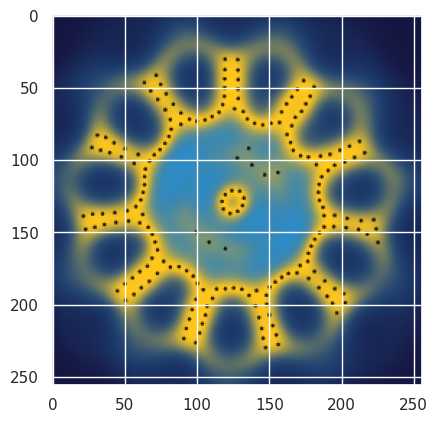

In [31]:
plt.imshow(img)

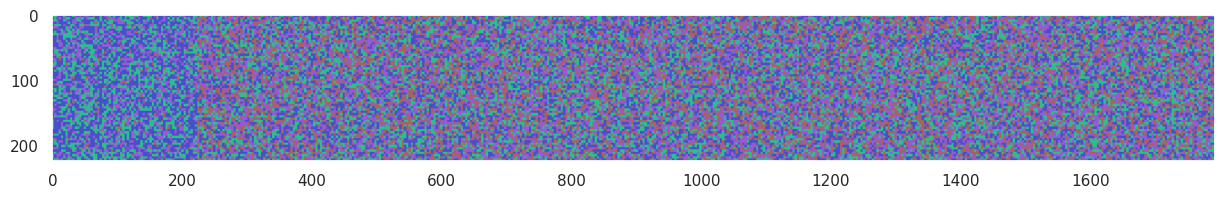

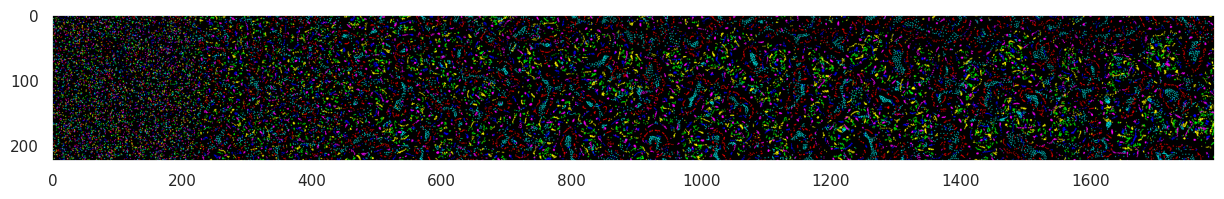

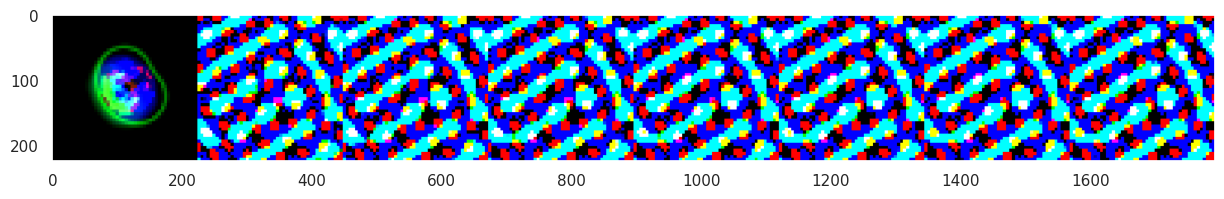

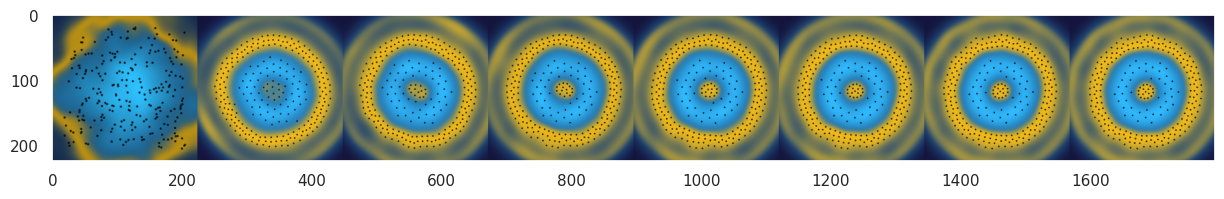

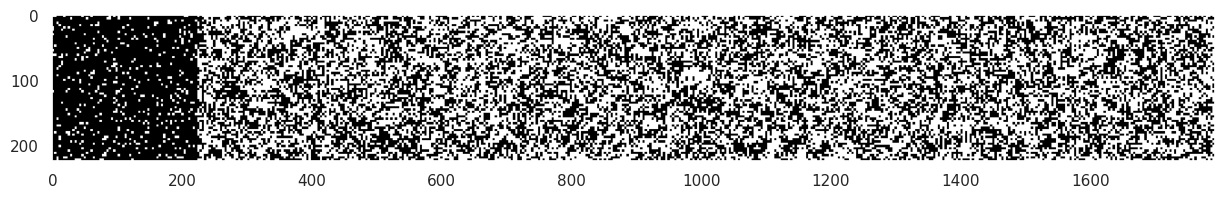

In [36]:
for sim in sims:
    rng = jax.random.PRNGKey(5)
    print(sim)
    show_vid(rng, sim.default_params(rng))


In [6]:
def get_vid(rng, params, sim, img_size=128, rollout_len=256):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
    return vid


In [37]:
rng = jax.random.PRNGKey(0)
sim = GameOfLife()
params = jax.vmap(sim.default_params)(split(rng, 16))
vid = jax.vmap(partial(get_vid, sim=sim))(split(rng, 16), params)
vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=4)
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f'./temp/gol.gif', vid, fps=10)

(16, 256, 128, 128, 3)
(16, 256, 130, 130, 3)
(256, 520, 520, 3)


In [11]:
for render_radius in tqdm((np.arange(5, 15)*1e-3)):
    rng = jax.random.PRNGKey(0)
    sim = ParticleLife(n_particles=5000, dt=0.01, render_radius=render_radius, sharpness=15., search_space='alpha')
    params = jax.vmap(sim.default_params)(split(rng, 1))
    vid = jax.vmap(partial(get_vid, sim=sim, img_size=512))(split(rng, 1), params)
    vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=1)
    vid = np.array((vid*255).astype(jnp.uint8))
    imageio.mimwrite(f'./temp3/plife_single_{render_radius:.3f}.gif', vid, fps=50)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:

search_space_sweep = [
    'alpha', 
    'alpha+mass', 
    'beta+alpha', 
    'alpha+c_dist+x_dist', 
    'alpha+c_dist', 
    'beta+alpha+c_dist+x_dist', 
    'beta+alpha+c_dist', 
    'beta+alpha+mass', 
    'beta+alpha+mass+c_dist+x_dist', 
    'beta+alpha+mass+c_dist', 
    'beta+alpha+mass+half_life+c_dist+x_dist', 
    'beta+alpha+mass+half_life+rmax+c_dist+x_dist', 
    'beta+alpha+mass+dt+half_life+c_dist+x_dist', 
    'beta+alpha+mass+dt+half_life+rmax+c_dist+x_dist',
]

for search_space in tqdm(search_space_sweep):
    rng = jax.random.PRNGKey(0)
    sim = ParticleLife(n_particles=5000, dt=0.003, render_radius=7e-3, sharpness=20., search_space=search_space)
    params = jax.vmap(sim.default_params)(split(rng, 16))
    vid = jax.vmap(partial(get_vid, sim=sim, img_size=256, rollout_len=512))(split(rng, 16), params)
    vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=4)
    vid = np.array((vid*255).astype(jnp.uint8))
    imageio.mimwrite(f'./temp4/plife_spaces_{search_space}.gif', vid, fps=50)

  0%|          | 0/14 [00:00<?, ?it/s]

2024-08-14 04:58:31.796864: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [22]:
vid.shape

(512, 1290, 1290, 3)

In [8]:
jnp.arange(32-1, 512, 32)

Array([ 31,  63,  95, 127, 159, 191, 223, 255, 287, 319, 351, 383, 415,
       447, 479, 511], dtype=int32)

In [6]:
def get_vid(rng, params, sim, img_size=128, rollout_len=256):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
    return vid

In [7]:
from models.models_boids import Boids

In [8]:
rng = jax.random.PRNGKey(1)
sim = Boids(n_boids=64, n_nbrs=8)
params = jax.vmap(sim.default_params)(split(rng, 9))
print('start simulating')
vid = jax.vmap(partial(get_vid, sim=sim, img_size=128, rollout_len=1024))(split(rng, 9), params)
print('done simulating')
vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=3)
vid = np.array((vid*255).astype(jnp.uint8))
imageio.mimwrite(f'../temp/debug/boids.gif', vid, fps=50)
print('done saving')

2024-08-24 08:17:55.912194: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


start simulating
done simulating
done saving


In [9]:
vid[0].shape

(390, 390, 3)

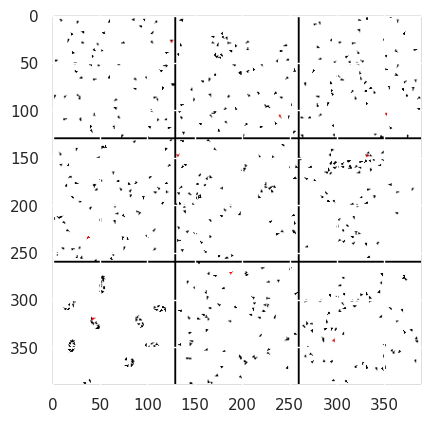

In [10]:
plt.imshow(vid[-1])
# plt.grid(False)